# E-Sport Commentary using DNN'S

#Motivation

Esports are hugely popular among people in many countries, with an estimated 450 million+ viewers each year. One of the key components to an entertaining broadcast is engaging commentary, which, in professional settings, is normally provided by professional commentators.

FIFA videogame commentary; however, is known for its repetitive and sometimes nonsensical style. Many FIFA players turn the game commentary off to make the game more enjoyable.  Because the commentary is prerecorded on these games, there is limited variability in the expresiveness of language when compared to what is seen on the screen. The narration thus becomes dull quickly or breaks immersion. 

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('bba4n5cS_SQ', autoplay=False)

Wouldn't it be cool to have narrators that actually commented what is going on in the screen accurately? How about having a narrator describing efusively your actions in games such as League of Legends or Starcraft? In addition to quality of life improvements in video games, video commentary is part of a more fundamental goal of AI. Can an AI match different domains of data in a meaningful way? In our case, the captioning model needs to be able to recognize meaningful patterns in video and match them to language to generate credible commentary, and the text to speech model needs to recognize patterns in text and match them to audio. Not an easy task to do. These are some of the challenges that we wanted to tackle with Deep E-Sport Commentary, a combination of two deep learning networks that will generate voice commentary automatically based on videos of Esports games. Let's give it a go!

# Problem Aproach

We aproach this problem in two steps, video captioning followed by text to speech:

## 1. Video Captioning
We first train an LSTM-Transformer architecture using a video captioning framework, where a single video can have multiple correct captions and the model learns to generate sentences based on the seen video-caption training data.

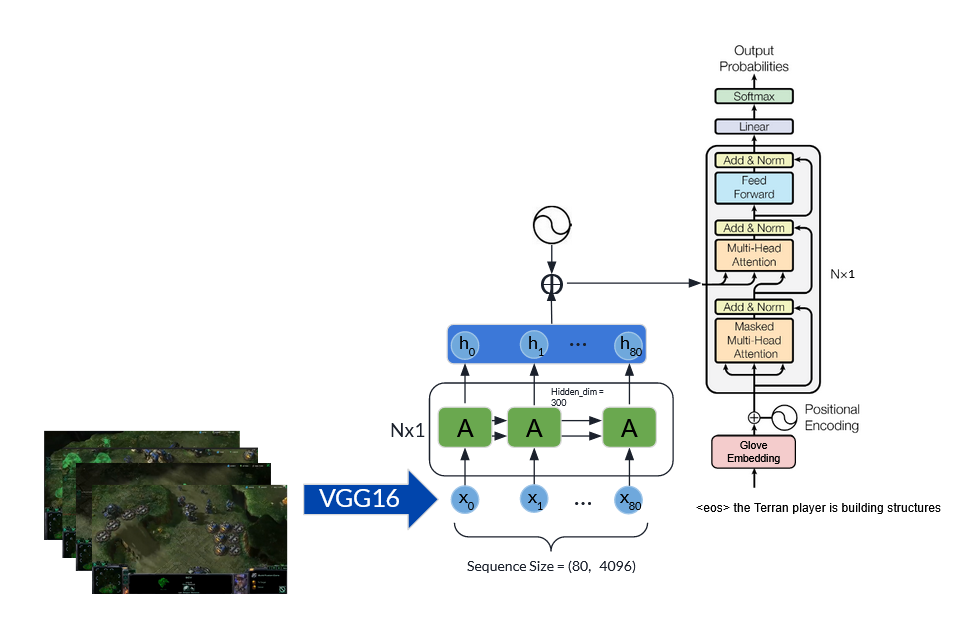


>Figure 1. Video Captioning Architecture.




## 2. Text-To-Speech (TTS)
We proceed to translate the generated captions by training a text to speech autoencoder on voice spectograms.

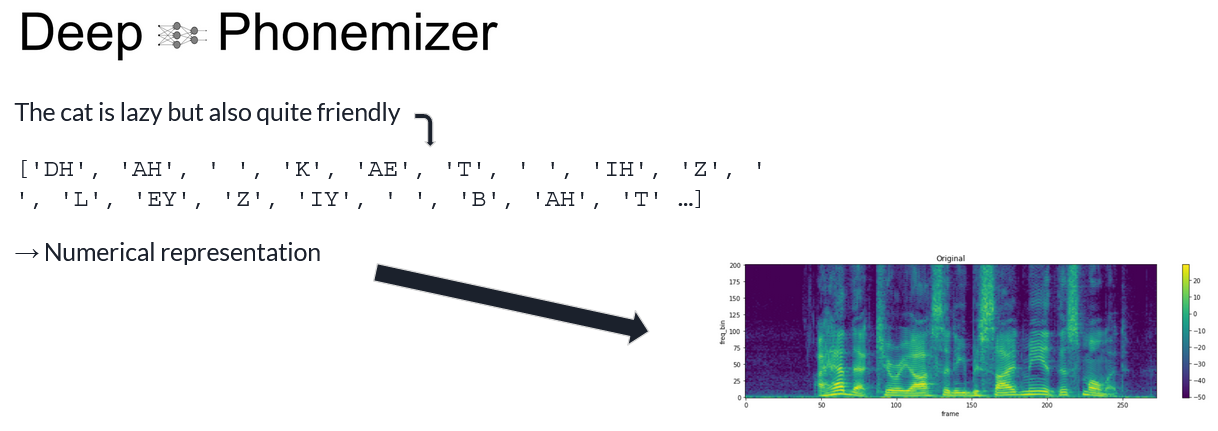

>Figure 2. Text to Speech Pipeline

# Video Captioning

The video captioner needs to take in video data and output a string of words for input to the text to speech model.

## Loading the Video Dataset

To train our models, first we need data! For video captioning, we generated our own small Starcraft II dataset, where players are controlling the Terran faction, one of three playable factions in the game. The dataset is composed of 5 starcraft videos which are further segmented into 25 clips, each 10 seconds in length. We then manually generated between 4 and 6 captions for each clip, with a mixture between captions of pure video description or more commentary-like text. Let's load the data and take a peek.

First, be sure to load the files to a folder in your drive 

In [2]:
# Drive
from google.colab import drive
drive.mount('/content/drive')
#Change this to the directory where you stored the files
file_dir = '/content/drive/MyDrive/MIE1517/Project/Walkthrough'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We use the pickle package to save data for easy loading when running the training loop more than once.

In [3]:
import pickle
import os
with open(os.path.join(file_dir,'train_dic.pkl'), 'rb') as f:
    train_dic = pickle.load(f)
with open(os.path.join(file_dir,'val_dic.pkl'), 'rb') as f:
    val_dic = pickle.load(f)

FileNotFoundError: ignored

The datasets are stored in dictionaries whose keys are the video ids, and whose values are the video captions. Note that there are some capitalized words. These should be lowercased to reduce the amount of tokens:

In [ ]:
for i, key in enumerate(train_dic.keys()):
  print(f'Video id: {key}')
  print(f'Captions:')
  for caption in train_dic[key]:
    print(caption)
  print("--------------")
  if i>0:
    break

The clip video files are stored in mp4 format. We can play the clip and show the corresponding captions in jupyter notebook using the following code.

In [ ]:
from moviepy.editor import *
video_id = list(train_dic.keys())[0]
clip_path = os.path.join(file_dir, 'starcraft_clips', video_id+'.mp4')
clip = VideoFileClip(clip_path)
print(train_dic[video_id])
#This line should always be last in the cell, otherwise the clip won't show
clip.ipython_display(width=720)


It's always good to get a feel for your data and check some statistics. That way you'll be able to sense the amount of padding needed, spot outliers, and fix overall bugs in the data that may ruin the training process later on. For now we'll only take a look at the amount of data we're working with.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def print_stats(data_dic):
  print(f"The number of clips in this dataset is {len(data_dic)}.")
  caption_lens = []
  vocab = set()
  max_len = 0
  min_len = 100
  for key in data_dic:    
    for caption in data_dic[key]:
      words = caption.split()
      caption_lens.append(len(words))
      if len(words)>max_len:
        long_cap = caption
        max_len = len(words)
      if len(words)<min_len:
        short_cap = caption
        min_len = len(words)
      vocab = vocab.union(words)

  print(f"The number of captions is {len(caption_lens)}.")
  print(f"The longest caption has {max(caption_lens)} words:")
  print(long_cap)
  print(f"The shortest caption has {min(caption_lens)} words:")
  print(short_cap)
  print(f"On average, a caption has {np.average(caption_lens):.1f} +- {np.std(caption_lens):.1f} words.")
  print(f"The vocabulary size of this dataset is {len(vocab)}.")
  print("\n")
  plt.xlabel('Caption Length')
  plt.ylabel('Probability')
  plt.hist(caption_lens, density=True)
  plt.grid(True)
  plt.show()
  return vocab

print("Train captions data:")
train_vocab = print_stats(train_dic)
print("Validation captions data:")
val_vocab = print_stats(val_dic)
print(f"The training and validation vocabularies share {len(train_vocab.intersection(val_vocab))} words")

We see that the captions aren't too long, so padding won't be an issue. Additionally, the training vocabulary has 756 distinct words, which is a relatively low size. The validation's vocabulary shares 214 words with the training vocabulary, so there are only 97 words left in the validation vocabulary that our model won't be privy too. We now continue with processing the clips.

## Video Clip Feature Extraction

Similarly to sentences being sequences made up of characters, videos are sequences made up of images. Therefore, by splitting video clips into different frames we'll be able to leverage the RNN architecture to encode time data from a sequence of images. We take inspiration (and code) from [1], split each clip into 80 images, and pass each image through a pretrained VGG16 network that acts as a feature extractor.

We extract the features from the second to last linear layer of the VGG16 network, and use those as inputs to the RNN. Using a pretrained model will accelerate training as our model won't have to learn to extract image features itself, it only has to learn what to do with the features.

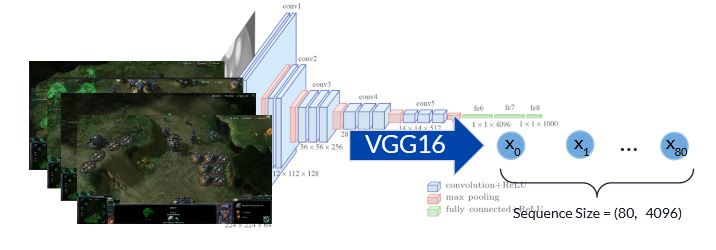
>Figure 3. Image feature pipeline.

We first load a pair of functions that allows use to 1) convert and save videos to a series of still frames and 2) load the saved images and rescale them to 224x224 for input into the VGG16 network.

In [ ]:
#Convert video to individual images. This code will create an img folder
#and store images there temporarily. They will be deleted once they are converted
#to features, so make sure to empty your Drive Thrash after finishing.
import cv2
import shutil

def video_to_frames(videos_folder, video):
  """
  Converts video files to individual images.
  Parameters:
    videos_folder: [str] Folder path where video is stored.
    video: [str] Video id
  Returns:
    image_list: [list] List of paths to generated frames.
  """
  frames_path = os.path.join(videos_folder, 'temporary_img_files')
  if os.path.exists(frames_path):
    shutil.rmtree(frames_path)
  os.makedirs(frames_path)
  video_path = os.path.join(videos_folder, video)
  count = 0
  image_list = []
  #Path to video file
  cap = cv2.VideoCapture(video_path)
  while cap.isOpened():
    ret, frame = cap.read()
    if ret is False:
      break
    cv2.imwrite(os.path.join(frames_path, 'frame%d.jpg' % count), frame)
    image_list.append(os.path.join(frames_path, 'frame%d.jpg' % count))
    count += 1
  cap.release()
  cv2.destroyAllWindows()
  return image_list

#Loads images in numpy vectors of size 224 x 224
def load_image(path):
  """
  Loads an image from path with size(224x224)
  Parameters:
    path: [str] Path of image to load
  Returns:
    img: [numpy.array] Loaded image array of size(224,224)
  """
  
  img = cv2.imread(path)
  img = cv2.resize(img, (224,224))
  return img

A very useful tool to learn about are hooks. They allow us to snatch the output of any layer of a pretrained model(or model in general). We'll use a hook to grab the features out of the third layer of the VGG16 classifier.

In [ ]:
import torch
import torchvision
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#Hook to obtain the features generated by any of the layers of a network
global view_output
def hook_fn(module, input, output):
  global view_output
  view_output = output #this is the variable where the features we're interested in will be stored

#Loads a model, right now only outputs from second to last linear layer of VGG16 are called
def model_load():
  """
  Loads VGG16 pretrained model with hook on third classifier layer to extract features.
  Parameters:
    None
  Returns:
    model: [torchvision.models.vgg.VGG] Pretrained VGG16 model
  """
  model = torchvision.models.vgg16(pretrained = True)
  model = model.to(device)
  hook = model.classifier[3].register_forward_hook(hook_fn)
  print("VGG16 Loaded")
  return model

The following function converts a video into features extracted from the pretrained VGG16 network, ready to be used by a pytorch model.

In [ ]:
#Returns video frames transformed into feature outputs from model 
def extract_features(videos_folder, video, model):
    """
    Transforms video image frames into features extracted from model.
    Parameters:
      videos_folder: [str] Folder path where video is stored.
      video: [str] Video id whose frames are to be extracted and converted into a tensor array
      model: [torch.model] Pretrained torch model
    Returns:
      img_feats: [torch.tensor] Video tensor features of size 4096x80
    """
    print(video)
    print(f'Processing video {video}')

    image_list = video_to_frames(videos_folder, video)
    samples = np.round(np.linspace(
        0, len(image_list) - 1, 80))
    image_list = [image_list[int(sample)] for sample in samples]
    images = torch.zeros((len(image_list), 3, 224, 224))
    
    #Convert images into torch tensors of appropiate shape
    for i in range(len(image_list)):
        img = load_image(image_list[i])
        img = torch.permute(torch.tensor(img), (2, 0, 1))
        images[i] = img
        images = images.to(device)
    #Pass the images through VGG16
    with torch.no_grad():
      model.eval()
      model(images)
      #img_feats is a vector of batch size = 80 and len 4096 features
      img_feats = view_output.to('cpu') #the hook allows us to retrieve the wanted features

    # cleanup
    shutil.rmtree(os.path.join(videos_folder, 'temporary_img_files'))
    return img_feats

videos_folder = os.path.join(file_dir, 'starcraft_clips')
video = list(train_dic.keys())[0]+'.mp4'
VGG16 = model_load()
img_feats = extract_features(videos_folder, video, VGG16)
print(type(img_feats))
print(img_feats.shape)

We have to convert all videos to tensor sequences and append them to each caption to create datasets ready for Pytorch's Dataloader. This may be a lengthy process, especially without an enabled GPU; therefore, we've precomputed and shared all training and validation VGG16 video tensor features in the starcraft_feat folder. We'll proceed to create the datasets necessary to train and validate our model using Pytorch.

In [ ]:
#Concatenate caption with video feature tensor to create train and test dataset for Dataloader
def create_dataset(train_dic, valid_dic, features_path, save=False, save_folder = 'datasets'):
  """
  Creates training and test datasets of captions concatenated with respective video feature tensor. Datasets
  ready for torch.utils.data.Dataloader.
  Parameters:
    train_dic: [dic] Training dictionary composed of captions for each video id key
    valid_dic: [dic] Validation dictionary composed of captions for each video id key
    features_path: [str] Folder path location of extracted video features.
    save: [bool] Set to True to save the datasets
    save_folder: [str] Folder where datasets will be saved in dataset.pt format.
  Returns:
    train_dataset: [list] List of training captions concatenated with respective video features and video ids. 
    test_dataset: [list] List of test captions concatenated with respective video features and video ids.
    
  """

  train_dataset = []
  valid_dataset = []

  for train_video in train_dic:
    train_feature_file = train_video + '.pt'
    
    if train_feature_file in os.listdir(features_path):
      feature_path = os.path.join(features_path, train_feature_file)
      feature_tensor = torch.load(feature_path)
      for caption in train_dic[train_video]:
        # Append id too to recover info later 
        train_dataset.append([caption, feature_tensor, train_video]) 


  for valid_video in valid_dic:
    valid_feature_file = valid_video + '.pt'

    if valid_feature_file in os.listdir(features_path):
      feature_path = os.path.join(features_path, valid_feature_file)
      feature_tensor = torch.load(feature_path)
      for caption in valid_dic[valid_video]:
        # Append id too to recover info later 
        valid_dataset.append([caption, feature_tensor, valid_video]) 
  
  if save:
    train_dataset_path = os.path.join(features_path, 'dataset_train.pt')
    valid_dataset_path = os.path.join(features_path, 'dataset_validation.pt')
    torch.save(train_dataset, train_dataset_path)
    torch.save(valid_dataset, valid_dataset_path)

  return train_dataset, valid_dataset
      
#Datasets
starcraft_features_path = os.path.join(file_dir, 'starcraft_feat')
train_dataset, val_dataset = create_dataset(train_dic, val_dic, starcraft_features_path, save=False)
print(len(train_dataset))
print(len(val_dataset))

The data is almost ready to train our model. However, there is still a key part missing. In a perfect world, neural networks can be trained using actual words as inputs and not sparse tokenizations or meticulously pre-trained embeddings. Since this is not a perfect world, we'll leverage useful torchtext functions to convert our captions to tokens as they are batched in the Dataloader.


## Caption Tokenization

We start by splitting each caption into a set of words with a tokenizer. We use torchtext's default english tokenizer, which splits sentences into basic english words and lowercases them. We'll also need an iterator that yields the tokens for each caption in the dataset. All the following code is based on [2].

In [ ]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

In [ ]:
en_tokenizer = get_tokenizer("basic_english")
caption = train_dataset[0][0]
tokens = en_tokenizer(caption)
print(tokens)

In [ ]:
def yield_tokens(data, tokenizer):
  """
  Yields tokens of captions in data dictionary
  Parameters:
    data: [list] List of dictionaries including video ids and their corresponding captions
    tokenizer: [function] Tokenizer function
  Yields:
    Tensor array of caption tokens, where each token is a word
  """
  for video in data:
      yield tokenizer(video[0])

for tokens in yield_tokens(train_dataset, en_tokenizer):
  print(tokens)
  break


Once we've split and preprocessed the words, we build a vocabulary using torchtext's build_vocab_from_iterator. This class allows us to transform any set of tokens within the vocabulary into indices. It can also include tokens for < unk >, < pad > , < bos >, and < eos > (UNKnown, PAD, Beginning Of Sentence, and End Of Sentence, respectively). Words outside the vocabulary of the vocab_transform are assigned the < unk > token index.

We'll only use the training set captions to build a vocabulary. That way, the model won't have information from the validation or test data in the training phase. Using just the training vocabulary provides a fairer comparison between the model's performance on the test set and the real world, where vocabulary is essentially limitless. 

In [ ]:
unk_token, pad_token, bos_token, eos_token = [0,1,2,3]
def build_vocab(data, tokenizer, min_word_freq=1):
  vocab_transform = build_vocab_from_iterator(yield_tokens(data, tokenizer),
                                              min_freq=min_word_freq,
                                              specials = (['<unk>', '<pad>', '<bos>', '<eos>']),
                                              special_first=True)
  vocab_transform.set_default_index(0)

  return vocab_transform

#Only use vocabulary from training data
vocab_transform = build_vocab(train_dataset, en_tokenizer) 
print(tokens)
#Words are tokenized using vocab_transform
print(vocab_transform(tokens))
print(len(vocab_transform))

We're almost ready to create our dataloader. Before that, we specify the order of the transformations that need to be made to the text before feeding it into the model and define one final transform. 

First we use the tokenizer to get individual words, then, we convert the words into indices using the vocab_transform. Lastly, we'll add the < bos > and < eos > tokens at the beginning and end of each caption, respectively. This will help our model know when to start and finish a sentence. At the same time, we convert the sequence of indexes into a torch tensor.

In [ ]:
#function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
  return torch.cat((torch.tensor([bos_token]), #Appends <bos> token index to beggining of sentence
                      torch.tensor(token_ids),
                      torch.tensor([eos_token]))) #Appends <eos> token index to end of sentence

# helper function to group together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

#text_transform function transforms text into tensors
text_transform = sequential_transforms(en_tokenizer, #Tokenization
                                       vocab_transform, #Numericalization
                                       tensor_transform) # Add BOS/EOS and create tensor

Using the previous transform, we'll define a collate function through which the data is transformed before being yielded by the dataloader. This is very useful, as we won't need to preprocess all the captions beforehand, saving plenty of memory. The collate function will also pad the shorter captions in the batch, yielding sequences of the same length.

In [ ]:
#collate function for torch dataloader
def collate_fn(batch):
    text_batch = []
    feature_batch = torch.tensor([])
    id_batch = []
    for caption, features, _ in batch:
      text_batch.append(text_transform(caption.rstrip("\n")))
      feature_batch = torch.cat((feature_batch, torch.unsqueeze(features, 0)))

    text_batch = pad_sequence(text_batch, batch_first=True, padding_value=1) #Fill shorter sentences with <pad> tokens
    return text_batch, feature_batch

We can finally build a dataloader and proceed to create a model and train it! Before proceeding, let's do a quick sanity check to see if the data is yielded correctly.

In [ ]:
#Train dataloader
train_loader = DataLoader(train_dataset, batch_size=20, collate_fn=collate_fn)  
train_iterator = iter(train_loader)

In [ ]:
text, features = train_iterator.next()
print(text.shape) #Shape should be (batch_size, max_sequence_len)
print(text[0]) #Index 2 for <bos> should be at the beginning, and there should be a 3 for <eos> followed by 1's for <pad> at the end
print(features.shape) #Shape should be (batch_size, 80, 4096)
print(features[0])

In [ ]:
#Check if the words make sense
vocab_transform.lookup_tokens(list(text[0]))

## Model

We are now ready to build the video captioning model. It is a encoding-decoding architecture, composed of an LSTM encoder to transform the image feature sequence and a transformer decoder that uses the transformed sequence to generate text. We begin by defining the encoding part.

###Encoder

The encoder part is composed by a single LSTM layer that uses the generated sequence of image features as inputs and encodes them into a sequence containing temporal data. 

Because the dimension of the encoded features need to match the dimension of the decoder inputs so that the cross attention matrix multiplications work out, the hidden dimension of the Long Short Term Memory network is 300. Using an RNN as an encoder proved to be much faster to train than the regular transformer encoder, while giving similar results.
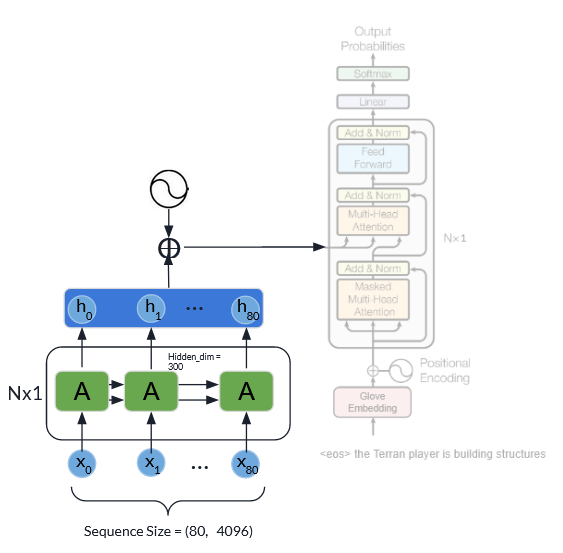

You'll also note that instead of using only the final hidden state to send to the decoder, we use all hidden states. We thought this would help preserve information from the beggining of the clip, and it achieved good results in practice. The hidden states are also a sequence, hence we add positional encoding before sending them into the decoder cross attention module. Let's take a look at how the encoder is constructed in code.

In [ ]:
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
encoder_lstm = nn.LSTM(input_size = 4096, #The dimension of the image features
                      hidden_size = 300, #To match glove embeddings
                      num_layers = 1, #Single layer
                      batch_first = True, #The shape of the image sequence is (Batch, Seq_len, Dim)
                      )

We don't input anything as the initial hidden state the LSTM, letting it be zeros as default. In addition, we use all the hidden state outputs and discard the cell state.

In [ ]:
hidden_states, _ = encoder_lstm(features) #No initial hidden state
print(hidden_states.shape) #Tensor of shape (Batch, Seq_len, Hidden_Dim)

We borred the following class from [2] to add positional encodings. This class allows the use of dropout, so that the decoder doesn't see a token in the sequence once in a while and learns to use information from the remaining tokens.

In [ ]:
# helper Module that adds positional encoding to the token embedding to introduce a notion of token order. 
# taken from https://pytorch.org/tutorials/beginner/translation_transformer.html
class PositionalEncoding(nn.Module):
    def __init__(self, emb_size, dropout, maxlen = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* np.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(0)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding):
        return self.dropout(token_embedding + self.pos_embedding[:, :token_embedding.size(1)])

Let's briefly look at what a positional encoding does by adding it to a zero "sequence" of 40 tokens and dimension 128. Note that for the first several dimensions, each position in the sequence has a different value. The neural network will learn to use this pattern to infer the temporal relationship between tokens.

In [ ]:
positional_encoding = PositionalEncoding(emb_size = 128, dropout = 0)
zero_sequence = torch.zeros((1,40,128))
position_sequence = positional_encoding(zero_sequence)
plt.figure(figsize=(14, 8))
ax = sns.heatmap(position_sequence.squeeze())
ax.set(xlabel='Dimension', ylabel='Sequence position')
plt.show()

Thus, the final output of the encoder and the input into the decoder's cross attention module (also called memory), is built as follows. We'll now look deeper into the decoding architecture.

In [ ]:
encoder_positional_encoding = PositionalEncoding(emb_size = 300, dropout = 0) #Same emb_size as hidden dims
hidden_states, _ = encoder_lstm(features) #No initial hidden state
print(hidden_states.shape)
memory = encoder_positional_encoding(hidden_states) #Add positional encoding to hidden states
print(memory.shape) #hidden states and memory should have the same shape

###Decoder

The decoder is made of a single layer of the transformer decoder architecture. We found that more layers didn't provide substantially better results and were much more computationally expensive to train. We use the transformer architecture to leverage cross attention, which will match text representations to relevant video featuresas seen in the middle of the diagram below [3]. In addition, the transformer uses self attention to learn the relationship between different words in a sentence and has been shown to be able to generate long sequences of realistic text [4], a feature that is useful for generating video commentary. We'll look at the architecture from the bottom up.
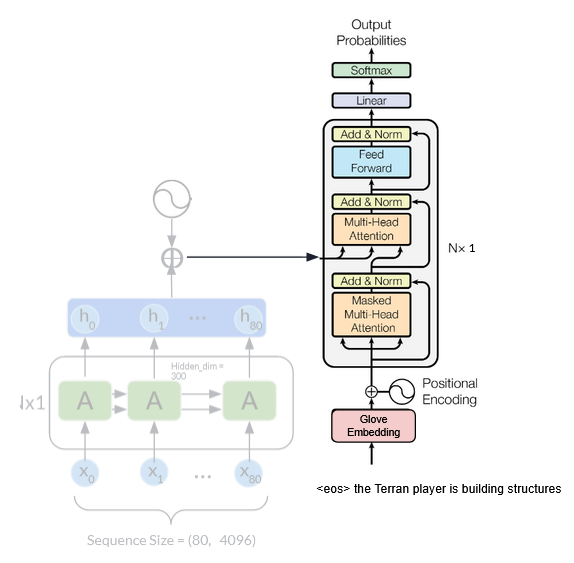

Text on teacher forcing training and masking

In [ ]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

generate_square_subsequent_mask(10)

text on glove embeddings, add comparisons of starcraft words in glove space

In [ ]:
glove = torchtext.vocab.GloVe(name="6B", dim=300)
text_embedding = nn.Embedding.from_pretrained(glove.vectors, padding_idx=pad_token)

In [ ]:
print(text[0].shape)
print(text_embedding(text[0]).shape)

text on transformer decoder layers, number of heads, gelu activation

In [ ]:
transformer_decoder_layer = nn.TransformerDecoderLayer(d_model = 300,
                                                      nhead = 10,
                                                      dim_feedforward = 2048,
                                                      dropout = 0,
                                                      batch_first = True,
                                                      activation = 'gelu'
                                                      )

transformer_decoder = nn.TransformerDecoder(transformer_decoder_layer, 
                                            num_layers = 1)

In [ ]:
activation = nn.GELU()
input = torch.linspace(-3.,3.,1000)
output = activation(input)
plt.plot(input, output)
plt.grid(True)

Text on pad masking function and utility

In [ ]:
def create_mask(tgt):
    tgt_seq_len = tgt.shape[1]
    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    tgt_padding_mask = (tgt == 1) #mask pad indeces

    return tgt_mask, tgt_padding_mask

text on decoder output, memory input and cross attention. also picture of cross attention 

In [ ]:
caption_mask, caption_padding_mask = create_mask(text)
decoder_positional_encoding = PositionalEncoding(300, 0)
glove_vectors = text_embedding(text)
decoder_input = decoder_positional_encoding(glove_vectors)

decoder_output = transformer_decoder(decoder_input, memory, caption_mask, None, caption_padding_mask)
print(decoder_output.shape)

text on missing MLP to obtain logits for CE loss

In [ ]:
decoder_ff = nn.Linear(300, len(vocab_transform))
final_output = decoder_ff(decoder_output)
print(final_output.shape)

### Putting it all together

text on overall model, dropout, separate forward method for training and encode/decode methods for inference and sanity check

In [ ]:
#VIDEO CAPTIONER BASED ON TRANSFORMERS
class VideoCaptioner(nn.Module):
  def __init__(self, num_encoder_layers = 1, num_encoder_tokens = 4096, encoder_dropout = 0.2, 
               num_decoder_layers = 1, num_decoder_heads = 10, embedding_latent_dim = 300,  decoder_dropout = 0.2,
               latent_dim = 2048, vocab_len = len(vocab_transform), positional_encoding_dropout =0.1, name ='VCDefault'):
    super().__init__()
    self.name = name
    self.vocab_len = vocab_len
    self.emb_size = embedding_latent_dim
    
    
    #Encoder
    self.encoder_positional_embedding = PositionalEncoding(embedding_latent_dim, dropout = positional_encoding_dropout)

    self.encoder_lstm = nn.LSTM(input_size = num_encoder_tokens,
                                hidden_size = embedding_latent_dim,
                                num_layers = num_encoder_layers,
                                dropout = encoder_dropout,
                                batch_first = True,
                                )

    #Decoder
    self.glove = torchtext.vocab.GloVe(name="6B", dim=embedding_latent_dim)
    self.text_embedding = nn.Embedding.from_pretrained(self.glove.vectors, padding_idx=1)
    self.decoder_positional_embedding = PositionalEncoding(embedding_latent_dim, dropout = positional_encoding_dropout)

    self.transformer_decoder_layer = nn.TransformerDecoderLayer(d_model = embedding_latent_dim,
                                                                nhead = num_decoder_heads,
                                                                dim_feedforward = latent_dim,
                                                                dropout = decoder_dropout,
                                                                batch_first = True,
                                                                activation = 'gelu'
                                                                )

    self.transformer_decoder = nn.TransformerDecoder(self.transformer_decoder_layer, 
                                                     num_layers = num_decoder_layers)

    #Logits
    self.decoder_ff = nn.Linear(embedding_latent_dim, vocab_len)

  def forward(self, video, caption):
    caption_mask, caption_padding_mask = create_mask(caption)

    #Encode
    memory, _ = self.encoder_lstm(video)
    memory = self.encoder_positional_embedding(memory)

    #Decode
    token_embedding = self.text_embedding(caption)
    decoder_input = self.decoder_positional_embedding(token_embedding)
    decoder_output = self.transformer_decoder(decoder_input, memory, caption_mask, None, caption_padding_mask)

    #Logits
    outputs = self.decoder_ff(decoder_output)

    return outputs

  def encode(self, video):
    memory, _ = self.encoder_lstm(video)
    memory = self.encoder_positional_embedding(memory)
    return memory
  
  def decode(self, caption, memory, caption_mask):
    token_embedding = self.text_embedding(caption)
    decoder_tgt = self.decoder_positional_embedding(token_embedding)
    output = self.transformer_decoder(decoder_tgt, memory, caption_mask)

    return output

In [ ]:
with torch.no_grad():
  model = VideoCaptioner()
  model = model.to(device)
  features = features.to(device)
  text = text.to(device)
  output = model(features, text)
  print(output.shape) #Check shape of output
  print(vocab_transform.lookup_tokens(list(torch.argmax(output[0],dim=1)))) #Verify caption generator is working

##Training

text on inference, training procedure, teacher forcing, loss function, optimizer and metrics

Text on inference and greedy decoding

In [ ]:
#Decode function based on https://pytorch.org/tutorials/beginner/translation_transformer.html
def caption_decode(model, video_features, max_len = 20):
  """
  Decodes caption generated by model's decoder.
  Parameters:
    model: [nn.Module] Trained torch caption generating model.
    video_features: [Tensor] Tensor of extracted video features.
    max_len: [int] Maximum possible length of generated caption 
  Returns:
    Sentence with vocab word indexes
  """
  video_features = video_features.unsqueeze(0).to(device)
  softmax = nn.Softmax(dim=2)
  ys = torch.ones(1, 1).fill_(2).type(torch.long).to(device) #We'll input <bos> to the decoder so that it can produce a sentence
  memory = model.encode(video_features)

  while ys.shape[1]<max_len: 
    caption_mask = (generate_square_subsequent_mask(ys.size(1)).type(torch.bool)).to(device)
    out = model.decode(ys, memory, caption_mask)
    probs = model.decoder_ff(out)
   
    #Take the word with the max probability
    _, next_word_probs = torch.max(probs, dim=2)
    next_word = next_word_probs[:,-1].item()


    ys = torch.cat([ys, torch.ones(1,1).type_as(ys.data).fill_(next_word).cuda()], dim=1)
    
    if next_word == eos_token: #Finish the sentence when the next most probable word is <eos>
        break
    
  return ys.squeeze().detach().cpu()

#Print generated captions
def generate_caption(model, video_features, vocab_transform, max_len=20):
  model.eval()
  with torch.no_grad():
    caption_tokens = caption_decode(model, video_features, max_len=20)
    return vocab_transform.lookup_tokens(list(caption_tokens))

Text on usual accuracy

In [ ]:
def batch_accuracy(preds, targets):
  accuracy = 0
  for prediction, target in zip(preds, targets):
    #only compare until target <eos>. everything else is pads, which the model doesn't learn
    eos_index = torch.where(target==3)[0]
    unpadded_target = target[:eos_index+1].cuda()
    token_preds = torch.argmax(prediction, dim=1)[:eos_index+1]
    accuracy += torch.sum(unpadded_target==token_preds).item()/(unpadded_target.shape[0])
    []
  return accuracy/targets.shape[0]

Text on bleu metric, possibly add meteor metric if time allows

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
def compute_bleu_score(model, data): #CHANGE THIS TO ACCEPT NEW DATASET FORMAT
  """
    Returns bleu score of  batch of data
  """
  running_bleu_score_1_gram = 0
  running_bleu_score_2_gram = 0
  running_bleu_score_3_gram = 0
  running_bleu_score_4_gram = 0
  for video in data:
    reference_corpus = []
    captions = data[video]
    for caption in captions:
      reference_corpus.append(caption.split())
    feature_file = video + '.pt'
    if feature_file in os.listdir(starcraft_features_path):
      feature_path = os.path.join(starcraft_features_path, feature_file)
      feature_tensor = torch.load(feature_path)
      prediction = print_caption(model, feature_tensor, vocab_transform) #fix this
      candidate_corpus = prediction[1:-1]
      running_bleu_score_1_gram += sentence_bleu(reference_corpus, candidate_corpus, weights=(1, 0, 0, 0))
      running_bleu_score_2_gram += sentence_bleu(reference_corpus, candidate_corpus, weights=(0.5, 0.5, 0, 0))
      running_bleu_score_3_gram += sentence_bleu(reference_corpus, candidate_corpus, weights=(0.33, 0.33, 0.33, 0))
      running_bleu_score_4_gram += sentence_bleu(reference_corpus, candidate_corpus, weights=(0.25, 0.25, 0.25, 0.25))
    
  print(running_bleu_score_1_gram)
  print(running_bleu_score_2_gram)
  print(running_bleu_score_3_gram)
  print(running_bleu_score_4_gram)

text on boiler plate plotting and training script general stats and features: epochs, batch, printing captions and metrics etc

In [ ]:
def plot_results(iteration, train_losses, train_accuracies, val_losses=None, val_accuracies = None):
    fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(12,5))
    
    ax1.plot(iteration, train_losses, label = 'Training loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', fontsize = 18)
    
    ax3.plot(iteration, train_accuracies, label = 'Training accuracy', )
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Accuracy', fontsize = 18)
    
        
    if val_losses is not None:
        ax2 = ax1.twiny()
        ax2.plot(iteration, val_losses, label = 'Validation loss', ls = '--')
        ax2.set_ylabel('Validation loss', fontsize = 18)

        ax4 = ax3.twiny()
        ax4.plot(iteration, val_accuracies, label = 'Validation accuracy', ls = '--')
        ax4.set_ylabel('Validation accuracy', fontsize = 18)
        
    fig.legend(loc=(0.85,0.1))
    fig.tight_layout()
    
    plt.show()

#Training script implementing CELoss
def train(model, train_loader, validation_loader=None, learning_rate = 0.0003, epochs=150, plot=True, save=False):
  folder_path = os.path.join(file_dir, 'starcraft_feat')
  train_video_id = train_dataset[0][2]+'.pt'
  val_video_id = val_dataset[0][2]+'.pt'
  print(train_video_id)
  print(val_video_id)
  train_feats = torch.load(os.path.join(folder_path, train_video_id))
  val_feats = torch.load(os.path.join(folder_path, val_video_id))

  criterion = nn.CrossEntropyLoss(ignore_index=1)
  optimizer = torch.optim.Adam(params = model.parameters(), lr=learning_rate)
  #scheduler = torch.optim.lr_schedule.LinearLR(optimizer, start_factor=0.0, total_iters=100)
  losses = []
  train_accuracies = []
  val_accuracies = []
  val_losses = []
  bleu_score = []

  for epoch in range(epochs):
    train_accuracy = 0
    running_loss = 0
    model.train()
    for caption, video_feats in train_loader:
      optimizer.zero_grad()
      video_feats = video_feats.to(device)
      input = caption[:,:-1].to(device)
      target = caption[:,1:].to(device)

      preds = model(video_feats, input)

      loss = criterion(preds.permute(0,2,1), target)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      train_accuracy += batch_accuracy(preds, target)

    if validation_loader is not None:
      model.eval() 
      val_running_loss = 0
      val_accuracy = 0
      with torch.no_grad():
        for caption, video_feats in validation_loader:
          video_feats = video_feats.to(device)
          input = caption[:,:-1].to(device)
          target = caption[:,1:].to(device)

          preds = model(video_feats, input)

          loss = criterion(preds.reshape(-1, preds.shape[-1]), target.reshape(-1))
      
          val_running_loss += loss.item()
          val_accuracy += batch_accuracy(preds, target)

      epoch_val_loss = val_running_loss/len(validation_loader)
      epoch_val_accuracy = val_accuracy/len(validation_loader)
      val_losses.append(epoch_val_loss)
      val_accuracies.append(epoch_val_accuracy)
    #scheduler.print_lr()
    epoch_loss = running_loss/len(train_loader)
    losses.append(epoch_loss)
    epoch_train_accuracy = train_accuracy/len(train_loader)
    train_accuracies.append(epoch_train_accuracy)

    print(generate_caption(model, train_feats, vocab_transform))
    print(generate_caption(model, val_feats, vocab_transform))

    if plot:
        plot_results(range(epoch+1), losses, train_accuracies, val_losses, val_accuracies)
        plt.show()

    print(f"Epoch {epoch} done. Train loss: {epoch_loss:.2f}")
    print(f"Val loss: {epoch_val_loss:.2f}. ")

    if save and (epoch+1)%15==0:
      torch.save(model, path+f"LSTM_Captioner_{model.name}_{epoch}.pt")

  return model

In [ ]:
model = VideoCaptioner()
model = model.to(device)
for p in model.parameters(): # xavier initialize model weights
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
trained_model = train(model, train_loader, val_loader, save = False)

# Text to Speech (TTS)

And now we have a sentence describing the action going on on the screen! In-game or post-game commentary cannot just be text for someone to read, though. Closed captions aren't entertaining to someone watching a game like Starcraft, and someone playing a game like FIFA without audio commentary wouldn't give the same sense of immersion.

To accomplish this, we've created an Autoencoder to convert the text characters in the descriptive string into audio.

## Data Collection

Before we build our model, we need to build our dataset. We built a sentence scraper to pull sentences from a speech therapy website [cite] to use for our data. We pulled 310 sentences from the site, and recorded 4-second audio clips of one of our team members speaking each of the sentences. Each of the sentences was stored in a text file labelled 'sentences.txt', and each of the audio recordings was stored as a '(number).wav' audio file, where (number) corresponds to the order of the sentences in the text file.

The audio was downsampled from the original 48 kHz to a few different sampling frequencies to reduce the size of the data. In the model we used 8 kHz samples, since human speech is still easily recognizable. The downsampled files were stored in .zip folders so they could be more easily uploaded to Colab.

The audio files and the code used to generate them is available in the *audio_data* folder.

First, we'll define the locations where we've stored our data files.

In [1]:
# Note - this cell can be skipped if the Video Captioning section was run

# Drive
from google.colab import drive
drive.mount('/content/drive')
#Change this to the directory where you stored the files
file_dir = '/content/drive/MyDrive/Colab Notebooks/Project/Walkthrough/'

Mounted at /content/drive


In [2]:
sentenceFile = 'audio_data/sentences.txt'
audioFolder = 'audio_data/files_8kHz/'

### Text (label) Load and Preprocessing
Now we'll load our training sentences from the text file.

In [3]:
sentences = [] # Load the sentences...
for line in open(file_dir+sentenceFile):
    line = line.strip('\n')
    sentences.append(line)

Next we'll need to process and tokenize the sentences using phoneme encodings. While characters make up the written representation of a language, the spoken word consists instead of phonemes, distinct sounds that are combined to make spoken words.

By using phoneme encodings instead of character encodings, our model can more accurately reconstruct speech from text input. To illustrate the difference between a character encoding and phoneme encoding, take the words **the** and **thistle** as examples. While both words include **th** characters, the sound made when we pronounce each word is different.

Using phoneme encodings reduces the ambiguity that the model has to interpret between.

To convert between text and phonemes, we'll use a pretrained model called Deep Phonemizer. First we need to install it.

In [4]:
# Install the text-to-phoneme processor.
!pip install deep-phonemizer

     |████████████████████████████████| 596 kB 10.9 MB/s 
  Created wheel for deep-phonemizer: filename=deep_phonemizer-0.0.17-py3-none-any.whl size=29727 sha256=e21887f444c2fba9a26a1016e0b3c017cc9c3e5204204ffb6cc52bbddc886f58
  Stored in directory: /root/.cache/pip/wheels/c0/09/57/64a017d46381d74a6b84869bbf763e3fe8579cc248ac65c651
Successfully built deep-phonemizer
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Then, import torch and torchaudio packages, as well as matplotlib and IPython for displaying intermediate data.

In [5]:
# Imports
import torch
import torchaudio
import matplotlib.pyplot as plt
import IPython

With all of our dependencies imported and installed, we can now instantiate our phoneme processor. We'll also print out some of the intermediate stages of the phonemizer to better visualize what it's doing.

In [6]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH # For the processor.
processor = bundle.get_text_processor()

# Create phoneme sentences (phontences) from text
def text2phoneme(processor, sentences):
    phontences = []
    for i in range(len(sentences)):
        tmp, _ = processor(sentences[i])
        phontences.append(tmp)
    return phontences

# Convert sentences to phonemes
phontences = text2phoneme(processor, sentences)

# Print out an example of the phonemized text
print(sentences[1])
print([processor.tokens[i] for i in phontences[1].squeeze(0)]) # Intermediate phontences.
print(phontences[1])

  0%|          | 0.00/63.6M [00:00<?, ?B/s]

The cat is lazy but is still quite friendly
['DH', 'AH', ' ', 'K', 'AE', 'T', ' ', 'IH', 'Z', ' ', 'L', 'EY', 'Z', 'IY', ' ', 'B', 'AH', 'T', ' ', 'IH', 'Z', ' ', 'S', 'T', 'IH', 'L', ' ', 'K', 'W', 'AY', 'T', ' ', 'F', 'R', 'EH', 'N', 'D', 'L', 'IY']
tensor([[39, 20, 11, 64, 16, 81, 11, 55, 94, 11, 65, 48, 94, 59, 11, 36, 20, 81,
         11, 55, 94, 11, 79, 81, 55, 65, 11, 64, 92, 32, 81, 11, 52, 78, 40, 67,
         38, 65, 59]])


For our text-to speech model to work correctly, we'll need all of our inputs to be the same length. As such we need to determine how long the longest of our phonemized sentences is so that we can pad all the others appropriately.

We'll then pad each of our phoneme sentences to the total length we just determined.

In [7]:
def padPhonemes(phontences, pad=0):
    # Get padding.
    for phontence in phontences:
        size = phontence.size(dim=1)
        if size > pad:
            pad = size

    # Replace each phontence with a padded phontence
    for i in range(len(phontences)):
        #target = torch.zeros(1,pad) # pad with zeros
        target = 11*torch.ones(1,pad) # pad with 11's, the phoneme character for spaces.
        size = phontences[i].size(dim=1)
        target[:,:size] = phontences[i]
        phontences[i] = target
    return phontences, pad

phontences, pad = padPhonemes(phontences)

# Display the total length
print(pad)

59


### Audio Load and Preprocessing
Now we'll load in the audio files that we recorded earlier in tensor form using torchaudio. Because the .wav file can store more than 1 channel of information (like in stereo audio), it is imported as a 2D tensor. Since our audio files are only recorded as one channel (mono), we can squeeze out that dimension.

Notice that we also pull out the sampling rate from the files as we load them in.

In [8]:
# Now get everything in tensor format.
# Will need to squeeze the audio to remove an extraneous dimension

audio_files = []
for i in range(len(sentences)):
  audio, sample_rate = torchaudio.load(file_dir+audioFolder+str(i)+".wav", format='wav', normalize=True)
  audio_files.append(audio.squeeze(0))

# Print out the lengths of the text and audio to make sure they're the same
print(len(phontences))
print(len(audio_files))

310
310


### Creating the TTS Dataset
Now we'll combine the text labels and the audio data into a dataset format that pytorch can use for training.

First we'll create tuples pairing the phoneme labels with the audio data.

In [9]:
# Create the tuples.
dataset = []
for i in range(len(phontences)):
  dataset.append((phontences[i],audio_files[i]))

# Check that the phontences are paired correctly with the audio
print(dataset[1])

(tensor([[39., 20., 11., 64., 16., 81., 11., 55., 94., 11., 65., 48., 94., 59.,
         11., 36., 20., 81., 11., 55., 94., 11., 79., 81., 55., 65., 11., 64.,
         92., 32., 81., 11., 52., 78., 40., 67., 38., 65., 59., 11., 11., 11.,
         11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11.,
         11., 11., 11.]]), tensor([0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 3.0518e-05, 0.0000e+00,
        0.0000e+00]))


Then, we'll split the dataset into training and validation sets, using approximately 10% of the data for validation.

In [10]:
# Percentage of data for validation (percentage is weird because we want an even 280-30 split)
valpct = 0.097
valSize = int(len(dataset)*valpct)
trainSize = len(dataset)-valSize

# Split the datasets
trainSet, valSet = torch.utils.data.random_split(dataset, [trainSize, valSize])

## Model
Here we define the autoencoder model.

### Imports and Installs
For this model, we'll use two packages that aren't included in the standard Colab packages. Torchinfo allows us to easily visualize the architecture of our models, and auraloss allows us to use a few audio-focused loss functions in our training code instead of MSELoss.

In [11]:
!pip install torchinfo
!pip install auraloss

In [12]:
# Import all relevant libraries
from torchinfo import summary
import auraloss

from tqdm import tqdm
import torchtext
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

### Define the Model Parameters
Here, we define the autoencoder class. Note that on our output we use a sigmoid activation and then rescale to +/- 1, since this is the scale at which the audio waveform samples are loaded.

In [13]:
class phonencoder(nn.Module):
  def __init__(self):
    super(phonencoder, self).__init__()
    self.name = "phonencoder"
    self.down1 = nn.Conv1d(1, 4, 5, stride=1)
    self.down2 = nn.Conv1d(4, 16, 5, stride=1)
    self.down3 = nn.Conv1d(16, 64, 5, stride=2)
    self.down4 = nn.Conv1d(64, 128, 5, stride=1)
    self.up1 = nn.Linear(2560, 8000)
    self.up2 = nn.Linear(8000, 31915)
    self.dropout = nn.Dropout(0.05)
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    out = self.down1(x)
    out = self.relu(out)
    out = self.down2(out)
    out = self.relu(out)
    out = self.down3(out)
    out = self.relu(out)
    out = self.down4(out)
    out = self.relu(out)
    out = out.view(-1,2560)
    out = self.up1(out)
    out = self.dropout(out)
    out = self.relu(out)
    out = self.up2(out)
    #out = self.dropout(out)
    out = self.sigmoid(out)

    return((out-0.5)*2)

Then, we'll instantiate the model and print out a summary. You'll notice that the model is quite large, due to the high number of neurons in the linear layers and the output size (approximately equal to the sample rate x the audio clip lengths).

In [14]:
# Get model summary.
model = phonencoder() # Need a gpu here for sure.

# Print model summary
print(summary(model, input_size=(1, 1, pad)))

Layer (type:depth-idx)                   Output Shape              Param #
phonencoder                              --                        --
├─Conv1d: 1-1                            [1, 4, 55]                24
├─ReLU: 1-2                              [1, 4, 55]                --
├─Conv1d: 1-3                            [1, 16, 51]               336
├─ReLU: 1-4                              [1, 16, 51]               --
├─Conv1d: 1-5                            [1, 64, 24]               5,184
├─ReLU: 1-6                              [1, 64, 24]               --
├─Conv1d: 1-7                            [1, 128, 20]              41,088
├─ReLU: 1-8                              [1, 128, 20]              --
├─Linear: 1-9                            [1, 8000]                 20,488,000
├─Dropout: 1-10                          [1, 8000]                 --
├─ReLU: 1-11                             [1, 8000]                 --
├─Linear: 1-12                           [1, 31915]                25

If it's available, we want to load the model onto the GPU, since this will allow us to parallelize many of the calculations and speed up the training process. We'll check whether it's available.

In [15]:
# Check if GPU is available
if torch.cuda.is_available():
    useCuda = True
else:
    useCuda = False

# Check the device
device = torch.device('cuda' if useCuda else 'cpu')
print("Using the")
print(device)

Using the
cuda


## Training
With the text-to-speech model defined and loaded, and our datasets loaded, we can then begin training the model!

First we'll define some helper functions to make our training code a little more compact.

In [16]:
def plotLoss(trainIters, trainLosses, valIters, valLosses):
  plt.title("Training Curve")
  plt.plot(trainIters, trainLosses, label="Train")
  plt.plot(valIters, valLosses, label="Validation")
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.show()

Then we'll define a few hyperparameters and build the torch dataloaders from the datasets we split out earlier.

In [17]:
# Hyperparameters
batch_size = 50
num_epochs = 1500
learning_rate = 0.001

# Build dataloaders
trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=batch_size, shuffle=True)
valLoader = torch.utils.data.DataLoader(valSet, batch_size=batch_size, shuffle=True)

Finally, we train the model.

In [18]:
# Define some empty lists for storing losses
trainIters, trainLosses, valIters, valLosses = [], [], [], []

# Counter
n = 0

# Put the model on the GPU if available
if useCuda:
    model.cuda()
    model = model.type(torch.cuda.FloatTensor)
else:
    model = model.type(torch.FloatTensor)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)    # use Adam
criterion = auraloss.time.SISDRLoss()                           # use the auraloss SISDRLoss function

# Training Loop
for epoch in tqdm(range(num_epochs)):
  
  for p, a in trainLoader:
    if useCuda:
      p, a = p.cuda(), a.cuda()
      p, a = p.type(torch.cuda.FloatTensor), a.type(torch.cuda.FloatTensor)
    else:
      p, a = p.type(torch.FloatTensor), a.type(torch.FloatTensor)

    out = model(p)
    
    loss = criterion(out, a)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    trainIters.append(n)
    trainLosses.append(float(loss)/batch_size)
    n += 1

  for p, a in valLoader:
    if useCuda:
      p, a = p.cuda(), a.cuda()
      p, a = p.type(torch.cuda.FloatTensor), a.type(torch.cuda.FloatTensor)
    else:
      p, a = p.type(torch.FloatTensor), a.type(torch.FloatTensor)

    out = model(p)
    loss = criterion(out,a)
    valIters.append(n)
    valLosses.append(float(loss)/batch_size)

  plotLoss(trainIters, trainLosses, valIters, valLosses)

Output hidden; open in https://colab.research.google.com to view.

## Loading a Pre-trained Text-To-Speech model
When we're building our model, we may want something to compare its outputs to qualitatively. For this purpose, we can load a pre-trained model called Tacotron2 along with a vocoder from the same torchaudio bundle we loaded deep phonemizer from.


In [19]:
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

Downloading: "https://download.pytorch.org/torchaudio/models/tacotron2_english_phonemes_1500_epochs_wavernn_ljspeech.pth" to /root/.cache/torch/hub/checkpoints/tacotron2_english_phonemes_1500_epochs_wavernn_ljspeech.pth


  0%|          | 0.00/107M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/torchaudio/models/wavernn_10k_epochs_8bits_ljspeech.pth" to /root/.cache/torch/hub/checkpoints/wavernn_10k_epochs_8bits_ljspeech.pth


  0%|          | 0.00/16.7M [00:00<?, ?B/s]

## Using the Model
Now that the model is trained, we can use it to generate audio files of speech. We can compare the audio generated by our encoder to the pretrained text to speech model.

Here we enter the string of text we'd like to convert to speech.

In [25]:
# This string is directly in the training data (unless it was moved to validation data by the random split)
string = ["The dog is very friendly and likes to play"]

# This is a fragment of training data
#string = ["The dog is very friendly"]

# This is a completely new sentence, something that was output by the video captioner
#string = ["the protoss army is healing the skirmish"]

# Enter a new string here and comment out the previous one if you'd like to 
#string = ["Text here"]

Then, we'll process the string into phonemes and pad it to the same length as our training files.

In [26]:
# Process the test string
phonemeString = text2phoneme(processor, string)

if len(phonemeString[0])>pad:
    print('The phonemized string is longer than the training data, choose a shorter one')
else:
    phonemeString, _ = padPhonemes(phonemeString, pad)
    phonemeString = phonemeString[0]

    # Move to the GPU if it was used
    if useCuda:
        phonemeString.cuda()
        phonemeString = phonemeString.type(torch.cuda.FloatTensor)
    else:
        phonemeString = phonemeString.type(torch.FloatTensor)

Finally, we feed our string of phonemes to the model and save the output data as an audio file.

In [27]:
x = model.forward(phonemeString.unsqueeze(0))

# Check the shape, it should be [1, 31915]
print(x.shape)

# Move the output to the cpu
x = x.cpu()
#x = x.squeeze(0).cpu()

# Save it as an audio file, and display
torchaudio.save("output_encoder.wav", x, sample_rate)
IPython.display.display(IPython.display.Audio("output_encoder.wav"))

torch.Size([1, 31915])


We can also run the same string through the pretrained TacoTron text to speech model to compare it to ours.

In [28]:
with torch.inference_mode():
  processed, lengths = processor(string[0])
  processed = processed.to(device)
  lengths = lengths.to(device)
  spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
  waveforms, lengths = vocoder(spec, spec_lengths)

torchaudio.save("output_tacotron.wav", waveforms[0:1].cpu(), sample_rate=vocoder.sample_rate)
IPython.display.display(IPython.display.Audio("output_tacotron.wav"))

# References

[1] https://medium.com/analytics-vidhya/video-captioning-with-keras-511984a2cfff

[2] https://pytorch.org/tutorials/beginner/translation_transformer.html

[3] Vaswani, Ashish, et al. "Attention is all you need." Advances in neural information processing systems 30 (2017).

[4] Brown, Tom, et al. "Language models are few-shot learners." Advances in neural information processing systems 33 (2020): 1877-1901.